<a href="https://colab.research.google.com/github/SRI-CSL/CoProver/blob/main/src/notebooks/220629_metitarski/coprover_metitarski_20221208.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CoProver: The Cueology of Proof 

## &#10024; `MetiTarski`- Variable Ordering Problem

**Copyright 2022 SRI International.**

## &#9776; Imports

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import rc
from tqdm import tqdm

In [2]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
try:
    from google.colab import data_table
    data_table.disable_dataframe_formatter()
    
    from google.colab import output
    output.enable_custom_widget_manager()
except Exception:
    print("Launched notebook locally")

In [4]:
from typing import List, Any, Dict

In [5]:
# install gdown library for .csv files download
try:
    import gdown
except ImportError:
    !pip install gdown

In [6]:
## install lazypredict for evaluation of multiple classifiers simultaneously
try:
    import lazypredict
except:
    !pip install lazypredict

In [7]:
from lazypredict.Supervised import LazyClassifier

## &#9997; Configuration

In [8]:
warnings.filterwarnings('ignore')

In [9]:
# origins of the .csv data files used
# True: originating within the signal-public GitHub repository
# False: need to be downloaded from a provided URL, especially useful if running on Colab
IS_LOCAL_FILE = False

In [10]:
# dictionary of files for this notebook to work
# the dictionary is composed of (filename, Google ID) key-value pairs

# v3: https://drive.google.com/file/d/1uC0WDg7fyZxwpc9UIgJznDAgT5WPqtA9/view?usp=sharing
# v4: https://drive.google.com/file/d/1uIoGOoHPsugXszScyU4HS9RKznX6tFeO/view?usp=sharing
DATASET_DICT = {
    'metitarski_dataset_v3.csv': '1uC0WDg7fyZxwpc9UIgJznDAgT5WPqtA9',
    'metitarski_dataset_v4.csv': '1uIoGOoHPsugXszScyU4HS9RKznX6tFeO'
    }

## &#9881; Functions

### &#9758; General

In [11]:
def path_exists(input_path: str) -> bool:
    return os.path.exists(input_path)

In [12]:
def check_file_status(input_path: str):
    if path_exists(input_path=input_path):
        print(f"- File {input_path.split('/')[-1]} exists locally at {input_path}!")
    else:
        if IS_LOCAL_FILE:
            print("- Something went wrong with the download. Please try again!")
        else:
            print(f"- IS_LOCAL_FILE is set to {IS_LOCAL_FILE}. The file is accessed via a public GitHub link!")

In [13]:
def download_dataset_from_google_drive(google_file_id: str, output_file_name: str, quiet_download: bool) -> str:
    file_path = f'./{output_file_name}'

    if not os.path.exists(file_path):
        gdown.download(id=google_file_id, output=output_file_name, quiet=quiet_download)
    else:
        print(f"{output_file_name} already exists!")
        
    return file_path

In [14]:
def get_dataset(dataset_name: str, is_local_file: bool) -> str:
    file_path = f'./{dataset_name}'

    if is_local_file:
        file_path = f'https://raw.githubusercontent.com/SRI-CSL/CoProver/main/data/{dataset_name}'
    else:
        if dataset_name in DATASET_DICT:
            file_path = download_dataset_from_google_drive(google_file_id=DATASET_DICT[dataset_name], output_file_name=dataset_name, quiet_download=False)
        else:
            print(f"{dataset_name} is not present in dataset dictionary! Please ensure the file name is correct!")
            return

    return file_path

### &#9758; Dataframe Manipulation

In [15]:
def get_dataframe_differences(df_1: pd.DataFrame, df_2: pd.DataFrame, target_columns: List[str]) -> pd.DataFrame:
    """Obtain the records that are in df_1 but NOT in df_2
       Solution inspired by: https://stackoverflow.com/questions/28901683/pandas-get-rows-which-are-not-in-other-dataframe

    Args:
      df_1: input dataframe 1
      df_2: input dataframe 2
      target_columns: list of columns to perform the difference operation upon

    Returns:
      A dataframe containing the records that are only in df_1 but not df_2
    """

    tmp_df = df_1.merge(df_2.drop_duplicates(), on=target_columns, how='left', indicator=True)

    result_df = tmp_df[tmp_df['_merge'] == 'left_only'][target_columns].copy()

    return result_df

### &#9758; Machine Learning Functions

In [16]:
def training_set_scaler(input_df: pd.DataFrame):
    scaler = StandardScaler()
    scaler = scaler.fit(input_df)

    return scaler

In [17]:
def scale_data(input_df: pd.DataFrame, scaler):
    df_scaled = pd.DataFrame(scaler.transform(input_df), index=input_df.index, columns=input_df.columns)

    return df_scaled

## &#9749; Downloads

In [18]:
# metitarski_dataset_v3.csv
path_metitarski_original = get_dataset(dataset_name='metitarski_dataset_v3.csv', is_local_file=IS_LOCAL_FILE)

metitarski_dataset_v3.csv already exists!


In [19]:
check_file_status(input_path=path_metitarski_original)

- File metitarski_dataset_v3.csv exists locally at ./metitarski_dataset_v3.csv!


In [20]:
# metitarski_dataset_v4.csv
path_metitarski_augmented = get_dataset(dataset_name='metitarski_dataset_v4.csv', is_local_file=IS_LOCAL_FILE)

metitarski_dataset_v4.csv already exists!


In [21]:
check_file_status(input_path=path_metitarski_augmented)

- File metitarski_dataset_v4.csv exists locally at ./metitarski_dataset_v4.csv!


## &#128722; Load data

**Naming Convention**

* All original metitarski related content (data, variables) will be followed by the `_1` indicators.
* The new dataset generated that consists of all possible variable permutations will be followed by `_2` indicators.

In [22]:
df_metitarski_1 = pd.read_csv(path_metitarski_original, sep='\t')

In [23]:
df_metitarski_2 = pd.read_csv(path_metitarski_augmented, sep='\t')

In [24]:
df_metitarski_1.shape, df_metitarski_2.shape

((6895, 16), (41369, 16))

In [25]:
df_metitarski_1.head()

,Unnamed: 0,file_id,input_file,label_file,nr_polynomials,max_total_degree,max_x1,max_x2,max_x3,prop_x1,prop_x2,prop_x3,prop_mon_x1,prop_mon_x2,prop_mon_x3,label
0,0,3940,poly3940.txt.ml,comp_times3940.txt,4,1,1,1,1,0.50,0.50,0.25,0.40,0.40,0.20,0
1,1,5554,poly5554.txt.ml,comp_times5554.txt,12,10,10,9,1,0.67,0.67,0.25,0.38,0.52,0.07,4
2,2,4063,poly4063.txt.ml,comp_times4063.txt,9,1,1,1,1,0.44,0.44,0.56,0.18,0.18,0.23,5
3,3,4732,poly4732.txt.ml,comp_times4732.txt,7,8,4,2,1,0.43,0.29,0.43,0.29,0.14,0.21,2
4,4,5205,poly5205.txt.ml,comp_times5205.txt,6,18,12,6,1,0.50,0.33,0.50,0.55,0.55,0.15,5


In [26]:
df_metitarski_2.head()

,Unnamed: 0,file_id,input_file,label_file,nr_polynomials,max_total_degree,max_x1,max_x2,max_x3,prop_x1,prop_x2,prop_x3,prop_mon_x1,prop_mon_x2,prop_mon_x3,label
0,0,415,poly415-perm0.txt.ml,comp_times415-perm0.txt,10,2,2,2,1,0.50,0.50,0.50,0.25,0.25,0.25,4
1,1,2230,poly2230-perm2.txt.ml,comp_times2230-perm2.txt,6,4,1,2,2,0.33,0.67,0.50,0.33,0.48,0.43,0
2,2,6506,poly6506-perm3.txt.ml,comp_times6506-perm3.txt,6,16,16,1,1,0.50,0.33,0.50,0.50,0.10,0.15,5
3,3,3998,poly3998-perm5.txt.ml,comp_times3998-perm5.txt,9,3,3,3,3,0.56,0.56,0.56,0.35,0.35,0.35,1
4,4,3730,poly3730-perm2.txt.ml,comp_times3730-perm2.txt,14,9,1,9,3,0.21,0.79,0.14,0.17,0.61,0.11,3


In [27]:
tmp_labels_1 = df_metitarski_1.groupby(df_metitarski_1.label).size()
tmp_labels_1

label
0     580
1     570
2     637
3    1215
4    1236
5    2657
dtype: int64

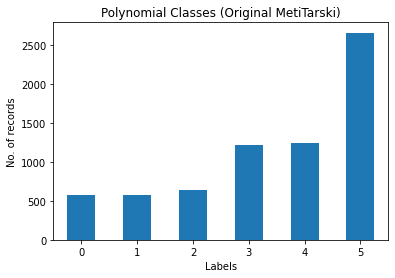

In [28]:
tmp_labels_1.plot.bar(
    title="Polynomial Classes (Original MetiTarski)", 
    xlabel="Labels", 
    ylabel="No. of records", 
    rot=0)

In [29]:
tmp_labels_2 = df_metitarski_2.groupby(df_metitarski_2.label).size()
tmp_labels_2

label
0    8505
1    7397
2    6731
3    6715
4    6188
5    5833
dtype: int64

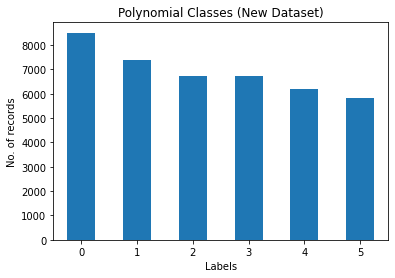

In [30]:
tmp_labels_2.plot.bar(
    title="Polynomial Classes (New Dataset)", 
    xlabel="Labels", 
    ylabel="No. of records", 
    rot=0)

## &#129504; MetiTarski - Variable Ordering

In [31]:
FEATURE_COLUMNS = ['nr_polynomials', 'max_total_degree', 'max_x1', 'max_x2', 'max_x3', 'prop_x1', 'prop_x2', 'prop_x3', 'prop_mon_x1', 'prop_mon_x2', 'prop_mon_x3']

FEATURE_COLUMNS

['nr_polynomials',
 'max_total_degree',
 'max_x1',
 'max_x2',
 'max_x3',
 'prop_x1',
 'prop_x2',
 'prop_x3',
 'prop_mon_x1',
 'prop_mon_x2',
 'prop_mon_x3']

### &#9758; MetiTarski Original

In [32]:
# original metitarski dataset features
df_features_1 = df_metitarski_1[FEATURE_COLUMNS].copy().reset_index()

In [33]:
df_features_1.drop(['index'], axis=1, inplace=True)

In [34]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_features_1, df_metitarski_1.label, test_size=0.1)

In [35]:
X_train_1.shape, y_train_1.shape, X_test_1.shape, y_test_1.shape

((6205, 11), (6205,), (690, 11), (690,))

In [36]:
# scale original training set
scaler_1 = training_set_scaler(input_df=X_train_1)

In [37]:
# rescale data
X_train_D1 = scale_data(input_df=X_train_1, scaler=scaler_1)
X_train_D1.head()

,nr_polynomials,max_total_degree,max_x1,max_x2,max_x3,prop_x1,prop_x2,prop_x3,prop_mon_x1,prop_mon_x2,prop_mon_x3
3850,-1.13,1.51,1.64,-0.61,-0.44,-0.41,-0.10,-1.05,1.54,-1.13,-1.26
718,-0.53,-0.42,-0.60,-0.13,1.76,-0.41,1.08,1.86,-0.13,0.70,0.64
352,-0.24,-0.42,-0.60,-0.13,-0.44,0.98,0.40,0.20,0.42,0.98,1.55
282,-0.24,6.01,6.13,-0.61,-0.44,0.06,-0.61,-0.80,2.46,-1.68,-1.53
2452,0.36,-0.42,-0.44,-0.13,1.76,0.67,0.29,1.08,0.77,0.07,1.09


In [38]:
X_test_D1 = scale_data(input_df=X_test_1, scaler=scaler_1)
X_test_D1.head()

,nr_polynomials,max_total_degree,max_x1,max_x2,max_x3,prop_x1,prop_x2,prop_x3,prop_mon_x1,prop_mon_x2,prop_mon_x3
4862,0.06,0.86,0.36,0.81,-0.44,-0.41,-0.10,0.70,0.17,1.28,-0.52
6017,-0.83,-0.10,0.04,-0.61,-0.44,0.24,-0.81,-1.40,-0.02,-0.96,-1.15
5881,-0.53,2.79,2.92,-0.61,-0.44,-0.41,-0.10,-0.47,1.30,-1.22,-1.11
1584,0.06,0.86,1.00,-0.13,-0.44,-1.21,-0.10,0.70,-0.38,-0.86,-0.19
6765,-0.24,0.54,0.68,3.66,-0.44,-0.87,-0.61,0.20,0.56,0.70,-0.50


In [39]:
lazy_clf_1 = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

In [40]:
models_1, predictions_1 = lazy_clf_1.fit(X_train_D1, X_test_D1, y_train_1, y_test_1)

100%|██████████| 29/29 [00:38<00:00,  1.33s/it]


In [41]:
models_1

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreeClassifier,0.59,0.52,None,0.59,0.02
ExtraTreesClassifier,0.59,0.52,None,0.59,0.71
RandomForestClassifier,0.59,0.51,None,0.59,0.93
LGBMClassifier,0.58,0.50,None,0.58,1.12
BaggingClassifier,0.57,0.50,None,0.56,0.37
DecisionTreeClassifier,0.56,0.50,None,0.57,0.04
LabelPropagation,0.58,0.49,None,0.58,2.29
LabelSpreading,0.58,0.49,None,0.58,4.14
KNeighborsClassifier,0.55,0.47,None,0.55,0.07


### &#9758; MetiTarski Augmented

In [42]:
# augmented metitarski dataset features
df_features_2 = df_metitarski_2[FEATURE_COLUMNS].copy().reset_index()

In [43]:
df_features_2.drop(['index'], axis=1, inplace=True)

In [44]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_features_2, df_metitarski_2.label, test_size=0.1)

In [45]:
X_train_2.shape, y_train_2.shape, X_test_2.shape, y_test_2.shape

((37232, 11), (37232,), (4137, 11), (4137,))

In [46]:
scaler_2 = training_set_scaler(input_df=X_train_2)

In [47]:
# rescale data
X_train_D2 = scale_data(input_df=X_train_2, scaler=scaler_2)
X_train_D2.head()

,nr_polynomials,max_total_degree,max_x1,max_x2,max_x3,prop_x1,prop_x2,prop_x3,prop_mon_x1,prop_mon_x2,prop_mon_x3
31418,0.66,-0.10,-0.48,-0.25,-0.02,-0.57,1.29,0.67,0.21,1.14,1.29
6433,0.36,-0.26,-0.25,0.22,-0.02,1.08,0.39,1.08,0.45,1.76,1.11
34132,0.96,-0.58,-0.25,-0.48,-0.49,2.02,0.33,-0.23,0.93,0.17,-0.22
6637,-0.53,0.54,-0.48,-0.25,1.61,0.05,0.05,-2.02,-0.82,-0.82,-0.09
10689,0.06,-0.10,0.68,-0.48,-0.49,0.05,-1.50,-0.73,0.16,-0.89,-0.36


In [48]:
X_test_D2 = scale_data(input_df=X_test_2, scaler=scaler_2)
X_test_D2.head()

,nr_polynomials,max_total_degree,max_x1,max_x2,max_x3,prop_x1,prop_x2,prop_x3,prop_mon_x1,prop_mon_x2,prop_mon_x3
3744,-0.53,-0.74,-0.48,-0.48,-0.25,-0.98,0.05,-0.98,-0.68,-0.04,-0.68
40205,-0.53,-0.10,0.68,-0.48,-0.49,1.08,-0.98,-2.02,0.76,-1.04,-1.49
37608,-0.23,-0.10,-0.48,-0.48,0.68,-0.39,-1.28,0.49,-0.99,-1.31,0.58
4465,1.26,-0.10,0.68,-0.48,-0.02,1.59,-1.50,1.60,1.56,-1.24,0.63
19979,-0.53,-0.90,-0.48,-0.48,-0.49,-0.98,-0.98,1.08,-0.79,-0.79,0.35


In [49]:
# lazy_clf_2 = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

In [50]:
# models_2, predictions_2 = lazy_clf_2.fit(X_train_D2, X_test_D2, y_train_2, y_test_2)

In [51]:
svm_D2 = svm.SVC(C=316, kernel='rbf', gamma=0.08, tol=0.0316)

svm_D2.fit(X_train_D2, y_train_2)

SVC(C=316, gamma=0.08, tol=0.0316)

In [52]:
svm_score_D2 = svm_D2.score(X_test_D2, y_test_2)
svm_score_D2

0.5680444766739183